# Deep learning con Tensorflow - módulo 1
## 0. Chequear el sistema
## 1. Ejemplo MNIST
## 2. Crear modelo
## 3. Entrenar modelo
## 4. Evaluar modelo
## 5. Guardar modelo
## 6. Utilizar modelo
## 7. Hyperparameter tuning
## 8. Explorar activacion del modelo

# 0. Vamos a revisar nuestro sistema y la GPU

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import os
import datetime

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Versión: ", tf.__version__)
print("Modo Eager: ", tf.executing_eagerly())
print("Versión Hub: ", hub.__version__)
print("GPU está", "disponible" if tf.config.experimental.list_physical_devices("GPU") else "NO DISPONIBLE")

Versión:  2.2.0
Modo Eager:  True
Versión Hub:  0.8.0
GPU está disponible


In [0]:
!pip install tensorflow_datasets

In [0]:
# Comprueba la version de CUDA y cuDDN
# CUDA 10.1
# cuDDN - La librería de Red Neuronal Profunda (Deep Neural Network) de NVIDIA CUDA: https://developer.nvidia.com/cudnn
# Fuente información: https://medium.com/@choowilson93/how-to-verify-cuda-and-cudnn-installation-d56a89bab0a8
!nvidia-smi 
!nvcc --version

Mon May 25 19:24:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     7W /  75W |     10MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Vamos a realizar un ejemplo con los datos de MNIST
En la documentación de Tensorflow podemos encontrar un amplio catálogo de datasets para probar nuestros modelos: https://www.tensorflow.org/datasets/catalog/overview

# Miramos que podamos cargar los datos

In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Importa tensorflow
import tensorflow as tf

# Bajamos los datos del set de MNIST y dividimos los datos en entrenamiento y test.
mnist = tf.keras.datasets.mnist 

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0 # Si dividimos entre 255 aprende mejor porque normalizamos los datos entre 0 y 1, normalmente se le resta la media y dividir por el error cuadratico para normalizar
print("[INFO] Hemos cargado los datos")
print("[INFO] Data shape - train y test (datos de validación del modelo)",x_train.shape, x_test.shape)
# (60000, 28, 28) (10000, 28, 28) 60.000 datos de 28x28 de entrenamiento, y lo mismo de validación. SON IMAGENES EN BLANCO Y NEGRO 

[INFO] Hemos cargado los datos
[INFO] Data shape - train y test (datos de validación del modelo) (60000, 28, 28) (10000, 28, 28)


# 2. Creamos el modelo

En esta parte de la página de Keras podéis encontrar toda la información sobre capas, optimizadores etc.: https://keras.io/api/layers/

In [18]:
# Definimos varios modelos que podemos seleccionar con un string de texto en la función "choose_model()"

# Definimos que modelo queremos utilizar de los que tenemos en la función.
model_to_choose = "2capas"

# Definimos los modelos que tendremos disponibles
def choose_model(text=""):
    if text =="2capas": 
      # Creamos el modelo:    Los modelos secuenciales son los más sencillos, la capa i solo está relacionado con la i-1 y la i+1. 
        model = tf.keras.models.Sequential([ #Secuencial: Defines una capa después de otra, y la capa i está conectada con la i+1 mediante una función
          tf.keras.layers.Flatten(input_shape=(28, 28)), # El Flatten es es pasar de un tamaño a otro tamaño lineal con 28x28= 784 neuronas de entrada
              # Con flattern la imagen de 28x28 lo convierte en un vector 
          tf.keras.layers.Dense(128, activation='relu'),  # Todas las neuronas del flatten las conectamos con la capa densa relu con 128 neuronas 
                    # Con la formula 784*128 +1 = 100480 parámetros
          tf.keras.layers.Dropout(0.2), #Luego hay un dropout. # Con mucho dropout el modelo se vuelve inestable, hay que tener cuidado
          tf.keras.layers.Dense(128, activation='relu'), # Luego otra densa relu
          tf.keras.layers.Dropout(0.2), # Luego otra dropoyt 
          tf.keras.layers.Dense(10, activation='softmax') # Y luego 10 capas densas softmax de salida. Como estamos clasificando es softmax
        ])
    elif text == "capa_grande":
      #Modelo con solo una capa oculta y 192 neuronas
        model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28)),
          tf.keras.layers.Dense(192, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='softmax')
        ])
    else:    
      #Modelo con solo una capa oculta y 128 neuronas  
        model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28)),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='softmax')
        ])
    return model

# Llamamos a la función 
model = choose_model(model_to_choose)

# Compilamos el modelo
model.compile(optimizer='adam', # Como calculo los pesos nuevos. Adam es uno de los optimizer + conocidos, como el SGD
              loss='sparse_categorical_crossentropy', # Forma de calcular el error, es decir, como de bueno o malo es un modelo. Es una función. MeanSquaredError es el error cuadrático medio, que es el + conocido. 
              metrics=['accuracy']) # Podemos hacer muchos tipos de metrica: mean, poission... 
              # Esto son valores de tensorflow keras!! Podemos buscar en la documentación :-)

print("[INFO] Modelo creado y compilado: ", model_to_choose)

# Y mostramos la arquitectura del modelo con model.summary()
model.summary() # Lista todas las capas del modelo y su nº de parámetros

# 100480    son muchos parámetros a optimizar, luego veremos como mejorar eso
# 128 parámetros por cada neurona + el umbral *10 =1290 

[INFO] Modelo creado y compilado:  2capas
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
______

In [0]:
# import os
# import datetime
# Load the TensorBoard notebook extension
# %reload_ext tensorboard

#!del -rf ./logs/ 
#print("[INFO] Current working directory ", os.getcwd())
#log_dir=".\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)

# 3. Entrenamos el modelo

In [19]:
# Una vez que ya tenemos el modelo lo entrenamos
model.fit(x_train, y_train, epochs=10,verbose=1,) # Necesita: las entradas de entrenamiento, las salidas de entrenamiento, las epocas que son  el numero de veces que pasa por el entrenamiento y el verbose te dice cuánta información quieres que salga. 
# SOLO ENTRENAMOS CON LOS DATOS DE TRAINING 


# Y cuando terminamos de entrenar el modelo mostramos el error de validación 
print("[INFO] Error de validacion del modelo")
model.evaluate(x_test, y_test, verbose=1) # Validación 
# CON LOS DATOS DE VALIDACIÓN (TEST) CALCULAMOS EL ERROR DE VALIDACIÓN DEL MODELO 


# Una epoca es cada vez que precide y entrena, pasa todo el dataset en una epoca

# El accuracy
# a veces un 0.1% de error no te lo puedes permitir!! Asi que hay que tener cuidado con los errores altos, hay aplicaciones que no pueden tener ningún error (por ejemplo, un coche que conduzca solo), en otras da igual (por ejemplo, la temperatura de tu casa)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2988 - accuracy: 0.9097
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1430 - accuracy: 0.9557
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1111 - accuracy: 0.9652
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0952 - accuracy: 0.9708
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0851 - accuracy: 0.9741
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0750 - accuracy: 0.9764
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0705 - accuracy: 0.9777
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0628 - accuracy: 0.9801
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0574 - accuracy: 0.9812
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.054

[0.07293175905942917, 0.9787999987602234]

# 4. Utilizamos el modelo
Una vez entrenado el modelo, ya lo podemos utilizar

[INFO] Error de validacion del modelo
313/313 - 1s - loss: 0.0778 - accuracy: 0.9780


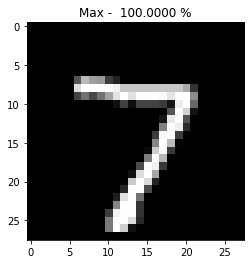

[INFO] predicciones:
[1.2301641e-11 6.9995247e-12 9.3145033e-08 4.6559968e-08 4.0312415e-13
 7.5996582e-14 6.3801652e-17 9.9999988e-01 2.7663848e-12 5.9789289e-09]


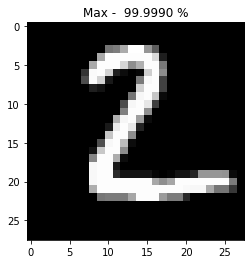

[INFO] predicciones:
[2.2633101e-13 9.9081844e-06 9.9999011e-01 2.9112854e-09 1.1840752e-15
 9.5343091e-13 3.7841458e-14 3.2575837e-08 5.1808255e-14 4.4622612e-17]


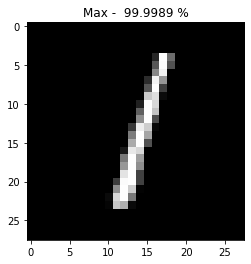

[INFO] predicciones:
[5.1880007e-09 9.9998879e-01 4.1087397e-08 6.8514536e-09 4.5783490e-06
 7.4726486e-08 1.4088025e-06 4.5392985e-06 5.8339003e-07 3.1427225e-09]


In [5]:
print("[INFO] Error de validacion del modelo")
model.evaluate(x_test, y_test, verbose=2)

# Número de imágenes de validad sobre las que las probamos
num_pred = 3 # Prediceme las 3 primeras 

# Predecimos algunos valores con el modelo
predictions = model.predict(x_test[:num_pred]) 

# Pintamos los valores con el modelo
from matplotlib import pyplot as plt

for i in range(num_pred):
    image = (x_test[i]*255).astype("int")  # Volvemos a multiplicar por que antes lo hemos dividido para normalizar
    plt.imshow(image, cmap="gray")
    plt.title("Max -  {:06.4f} %".format(predictions[i].max()*100) )
    plt.show()
    print("[INFO] predicciones:")
    print(predictions[i]) 



In [6]:
# Podemos también guardar el modelo. Guardar los pesos y el gráfico de la arquitectura como minimo. También podríamos guardar checkpoint después de cada época cuando estamos entrenando, por ejemplo, por si se cuelga el ordenador cuando estamos entrenando, para no perder el proceso
  # También podemos guardar la configuración de entramiento
from os import makedirs

makedirs('modelo', exist_ok=True)
model.save('modelo/') 
# Hemos guardado este modelo
print("[INFO] Hemos guardado el siguiente modelo")
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: modelo/assets
[INFO] Hemos guardado el siguiente modelo
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense) 

In [0]:
# Podemos cargar después el modelo
model = tf.keras.models.load_model('modelo/')

# Y tenemos nuestro modelo de vuelta 
print("[INFO] Siguiente modelo leido")
model.summary()

[INFO] Siguiente modelo leido
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
____________________

#Pero, ¿Cómo desplegar nuestro modelo en la nube?
Existe algo más allá de nuestros notebooks, este es un ejemplo que podría venir bien sobre cómo implementar nuestros modelos en la nube: https://www.aprendemachinelearning.com/tu-propio-servicio-de-machine-learning/

# Ejercicio 1 - Chequea diferentes para mejorar el error

In [13]:
# 1.A) INCLUYE MÁS NEURONAS EN LA MISMA CAPA O EN OTRA.

# Crearemos una función donde recogeremos nuestro modelo de "2 capas"
# y añadiremos más neuronas a la primera.

def modelo_mas_neuronas():
    model = tf.keras.models.Sequential([
                                        # AQUI LO QUE APLICAMOS ES MÁS NEURONAS, NO CAPAS DE CONVOLUCIÓN
          tf.keras.layers.Flatten(input_shape=(28, 28)), # Flatten: con el bidimensional genero un vector.   
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='softmax')
        ])
    return model

modelo_2 = modelo_mas_neuronas()

# Volvemos a compilar el modelo, a pedir un 'summary', comenzaremos el entrenamiento
#y calculamos el error de validación. 
#Esta vez vamos a crear una función para poder emplearla en el siguiente 
#ejemplo, de esta manera no habrá que repetir todo el código de nuevo.

def compila_y_mas(modelo):
    modelo.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    print("Summary: ")
    modelo.summary()
    # Entrenamos y mostramos el error de validación
    modelo.fit(x_train, y_train, epochs=10,verbose=1)
    print("[INFO] Error de validacion del modelo: ")
    modelo.evaluate(x_test, y_test, verbose=1)

compila_y_mas(modelo_2)


Summary: 
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
______________________________________

In [14]:

# 1.B) ¿QUÉ PASA SI INCLUYES ALGUNA CAPA DE CONVOLUCIÓN?
#Documentación Keras sobre las distintas capas de convolución: https://keras.io/api/layers/convolution_layers/

# Agregaremos una capa de convolución 2D (que pueden emplearse en las matrices 2d de las imágenes en blanco y negro, por ejemplo)
# Pero, 1º, tenemos que hacer un reshape de nuestra 'x'... ¿por qué? La convolución precisa un input
# con ndim=4 (un shape de 4 factores o 4 dimensiones), sin embargo, si vamos a las primeras celdas
# de este notebook, podremos comprobar que x_train = (60000, 28, 28) y x_test = (10000, 28, 28), donde el 1er número
# indica la cantidad de números pintados de cada muestra y los 2 siguientes indican la medida en píxeles de cada imagen.
# Para la capa convolucional necesitaremos incluir una 4º dimensión que representará el nº de canales de la imagen
# En nuestro caso será = 1, porque son imágenes en blanco y negro.

#Reshape
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


#Función de creación de modelo con nuestra capa extra de convolución
def modelo_convol():
    model = tf.keras.models.Sequential([
                                        # AÑADIREMOS CAPAS DE CONVOLUCIÓN, NO SOLO NEURONAS, PARA SACAR MÁS INFORMACIÓN DE LA IMAGEN
          tf.keras.layers.Conv2D(32, (3,  3), padding='same', activation='relu', input_shape=(28,28,1)), # En un filtro de convolución, con los mismos pesos se aplica a varias posiciones
            # La convolucion te identifica caracteristicas en la imagen y te calcula nuevas. Tienes 32 filtros de 3x3 de convolucion y por cada filtro te calcula una imagen -> 10x32 es 320
          tf.keras.layers.Flatten(),
              # Flatten lo que hace es cambiar el formato a un vector, no es una capa convolucional, es como un reshape 
      
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='softmax')
        ])
    return model

modelo_3 = modelo_convol()

#Y volvemos a llamar a la función que hemos creado para compilar, entrenar y evaluar el modelo (en 1.A)
modelo_3 = compila_y_mas(modelo_3)


## 
# conv2d (Conv2D)              (None, 28, 28, 32)        320 
# De una imagen salen 32 imágenes diferentes . 

Summary: 
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)     

In [15]:
# 1.C) ANÁLISIS DE DATOS

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn 
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, r2_score
import pandas as pd

# Crea una matriz de confusión y píntala, ¿dónde se esta equivocando el modelo?

# Creamos la variable y_pred para poder comparar los datos de test 
# con los predichos por el modelo (en este caso el último que hemos hecho)
# La segunda línea nos permitirá obtener el índice(que es igual que el valor 
# en este caso), y no las probabilidades que nos muestra por defecto x_test

Y_pred = modelo_3.predict(x_test) 
y_pred = np.argmax(Y_pred, axis=1)

# Mirar la distribución de los datos
plt.figure(figsize=(5,5))

#Añadimos el valor de R**2 y representamos la gráfica con Seaborn y Matplotlib
r2 = round(r2_score(y_test, y_pred), 2) 
texto = 'R2 ='+ str(r2)
plt.text(1, 8, texto, fontsize=20)

sn.regplot(y_test, y_pred, color='b', scatter_kws={'alpha':0.1}) #Regresión + Scatter de Seaborn
plt.title('Regresión lineal + Scatter Plot')
plt.xlabel('PREDICCIÓN')
plt.ylabel('VALOR REAL')
plt.grid()
plt.show()

#Creamos nuestra matriz y hacemos nuestro plot
cm = confusion_matrix(y_test, y_pred, normalize= 'true')

plt.figure(figsize=(10,10))
sn.heatmap(cm, annot=True, fmt='.3f', cmap = plt.get_cmap('Blues') ) #la opción fmt permite formatear los valores y ajustarlos a 3 decimales en nuestro ejemplo
plt.title('MATRIZ DE CONFUSIÓN ')
plt.xlabel('PREDICCIÓN')
plt.ylabel('VALOR REAL')
plt.imshow(cm)

plt.show()

# Pintar la curva ROC
# Si tratamos de hacer una curva ROC nos arrojará un error si no pasamos a modo binario primero
# nuestros datos, para hacer esto sin tener que repetir el ejercicio recurriremos a Pandas
# y su método get_dummies

def plot_multiclass_roc(modelo, x_test, y_test, n_classes, figsize=(17, 6)):
    y_score = modelo_3.predict_proba(x_test)

    # fpr = tasa de falsos positivos / tpr = tasa de verdaderos positivos
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculamos los dummies una vez
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC para cada clase (nuestros 10 dígitos en los que se divide la clasificación)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('Tasa Falsos Positivos')
    ax.set_ylabel('Tasa Verdaderos Positivos')
    ax.set_title('Curva ROC')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC (area = %0.2f) para label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid()
    sn.despine()
    plt.show()

plot_multiclass_roc(modelo_3, x_test, y_test, n_classes=10, figsize=(10, 8))
# Como podemos comprobar, las curvas ( por cada dígito) salen muy apiñadas, ya que
# su ROC es prácticamente la misma. 


AttributeError: ignored

Localización (índices) de los errores en las predicciones del modelo: 
 [151, 247, 321, 340, 445, 582, 613, 691, 717, 740, 844, 882, 938, 939, 956, 1014, 1033, 1039, 1112, 1156, 1226, 1232, 1242, 1260, 1319, 1328, 1393, 1414, 1500, 1522, 1527, 1530, 1654, 1681, 1709, 1722, 1790, 1828, 1878, 1901, 1955, 2035, 2043, 2052, 2118, 2129, 2130, 2135, 2189, 2280, 2293, 2369, 2414, 2422, 2462, 2488, 2654, 2771, 2778, 2896, 2921, 2927, 2939, 2953, 3030, 3073, 3225, 3289, 3422, 3475, 3503, 3520, 3558, 3597, 3726, 3778, 3808, 3838, 3853, 3906, 4075, 4140, 4176, 4199, 4201, 4289, 4536, 4571, 4578, 4639, 4740, 4807, 4814, 4823, 4911, 5228, 5265, 5331, 5634, 5887, 5888, 5936, 5955, 5997, 6101, 6166, 6173, 6555, 6574, 6576, 6577, 6597, 6625, 6631, 6632, 6740, 6847, 7216, 7849, 8094, 8277, 8325, 8332, 8408, 8519, 8520, 8527, 9009, 9015, 9019, 9634, 9642, 9679, 9729, 9839, 9879, 9982]


Using TensorFlow backend.



 Data augmentation con Zoom: 



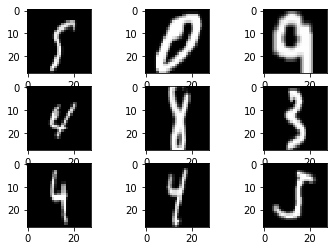

In [0]:
# Busca los ejemplos donde la red se esta equivocando
#Esto es tan simple como hacer una comprehension list

index_errores = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]] 
print("Localización (índices) de los errores en las predicciones del modelo: \n", index_errores)


# Intenta pensar en una forma de aumentar el set de datos de entrenamiento. ¿Cómo podrías hacer data augmentation?

# Para aumentar el dataset con los datos que tenemos podríamos hacer variaciones en las imágenes
# creando giros, zooms, cambiando colores, etc.
# Hagamos un ejemplo generando imágenes con zoom:

from keras.preprocessing.image import ImageDataGenerator
  
datagen = ImageDataGenerator(zoom_range=0.5)  

# fit the data
datagen.fit(x_train)
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(28, 28), cmap=('gray')) 
    print('\n Data augmentation con Zoom: \n')
    plt.show()
    break


# Ejercicio 2 - Hyperparameter tuning

**TIP**:  
La gran Wikipedia nos dice que "el ajuste de hiperparámetros es elegir un conjunto de hiperparámetros óptimos para un algoritmo de aprendizaje". Un hiperparámetro es un parámetro cuyo valor se establece antes de que comience el proceso de aprendizaje.

Para este ejemplo usaremos el RandomizedSearchCV de SKLearn

Fuente:   
https://medium.com/swlh/hyper-parameter-tuning-for-keras-models-with-scikit-learn-library-dba47cf41551

Hyperparameter tuning en SKLearn:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [0]:
# Una vez que ya entendemos el funcionamiento de esta red, 
# ¿Cuáles son los parámetros de la arquitectura con los que podemos jugar?
# ¿Puedes hacer una funcion que corra varias veces la red desde cero con diferentes configuraciones?

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

#Vamos a crear un nuevo modelo con el que poder experimentar
(X_train, y_trn), (X_test, y_tst) = mnist.load_data()
X_trn = X_train[..., np.newaxis].astype(np.float32) / 255.
X_tst = X_test[..., np.newaxis].astype(np.float32) / 255.

def build_model(var_activation='relu',var_optimizer='adam'):
    model = Sequential()
    model.add(Flatten(input_shape=[28, 28, 1]))
    model.add(Dense(64,activation=var_activation))
    model.add(Dense(32,activation=var_activation))
    model.add(Dense(16,activation=var_activation))
    model.add(Dense(10,activation='softmax'))
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=var_optimizer,
                metrics=["accuracy"])
    return model

model_default = build_model()

# Creamos listas con los parámetros que queremos ir cambiando y probando
# almacenándolas en forma de diccionario
_activations=['tanh','relu','selu']
_optimizers=['sgd','adam']
_batch_size=[16,32,64]
params=dict(var_activation=_activations,
            var_optimizer=_optimizers,
            batch_size=_batch_size)
print(params)

# Para usar RandomizedSearchCV, primero debemos hacer 
# que nuestro modelo Keras sea compatible con la biblioteca sklearn
# y utilizaremos el wrapper de keras para scikitlearn: KerasClassifier.
# Además, usaremos el random seed de Numpy para inicializar los pesos
# de nuestro modelo con los mismos valores en cada iteración.

model = KerasClassifier(build_fn=build_model,epochs=4,batch_size=16)
np.random.seed(42)

rscv = RandomizedSearchCV(model, param_distributions=params, cv=3, n_iter=10)
rscv_results = rscv.fit(X_trn,y_trn)
print('Best score is: {} using {}'.format(rscv_results.best_score_, rscv_results.best_params_))



{'var_activation': ['tanh', 'relu', 'selu'], 'var_optimizer': ['sgd', 'adam'], 'batch_size': [16, 32, 64]}
Train on 40000 samples
Epoch 1/4
40000/40000 [==============================] - 7s 178us/sample - loss: 0.7197 - accuracy: 0.8310
Epoch 2/4
40000/40000 [==============================] - 7s 175us/sample - loss: 0.3303 - accuracy: 0.9126
Epoch 3/4
40000/40000 [==============================] - 7s 172us/sample - loss: 0.2600 - accuracy: 0.9291
Epoch 4/4
20000/20000 [==============================] - 2s 121us/sample - loss: 0.2146 - accuracy: 0.9373
Train on 40000 samples
Epoch 1/4
40000/40000 [==============================] - 7s 175us/sample - loss: 0.7180 - accuracy: 0.8285
Epoch 2/4
40000/40000 [==============================] - 7s 170us/sample - loss: 0.3266 - accuracy: 0.9119
Epoch 3/4
40000/40000 [==============================] - 7s 170us/sample - loss: 0.2533 - accuracy: 0.9290
Epoch 4/4
20000/20000 [==============================] - 2s 124us/sample - loss: 0.2156 - accuracy

20000/20000 [==============================] - 4s 182us/sample - loss: 0.1248 - accuracy: 0.9651
Train on 40000 samples
Epoch 1/4
40000/40000 [==============================] - 4s 91us/sample - loss: 0.5213 - accuracy: 0.8760
Epoch 2/4
40000/40000 [==============================] - 3s 65us/sample - loss: 0.2046 - accuracy: 0.9432
Epoch 3/4
40000/40000 [==============================] - 3s 63us/sample - loss: 0.1441 - accuracy: 0.9586
Epoch 4/4
20000/20000 [==============================] - 1s 56us/sample - loss: 0.1273 - accuracy: 0.9631
Train on 40000 samples
Epoch 1/4
40000/40000 [==============================] - 3s 72us/sample - loss: 0.4850 - accuracy: 0.8798
Epoch 2/4
40000/40000 [==============================] - 2s 62us/sample - loss: 0.1928 - accuracy: 0.9468
Epoch 3/4
40000/40000 [==============================] - 2s 62us/sample - loss: 0.1356 - accuracy: 0.9617
Epoch 4/4
20000/20000 [==============================] - 1s 55us/sample - loss: 0.1477 - accuracy: 0.9560
Train on 

20000/20000 [==============================] - 3s 166us/sample - loss: 0.1817 - accuracy: 0.9453
Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 15s 253us/sample - loss: 0.2766 - accuracy: 0.9148
Epoch 2/4
60000/60000 [==============================] - 15s 250us/sample - loss: 0.1222 - accuracy: 0.9634
Epoch 3/4
60000/60000 [==============================] - 14s 237us/sample - loss: 0.0909 - accuracy: 0.9717
Epoch 4/4
60000/60000 [==============================] - 14s 240us/sample - loss: 0.0753 - accuracy: 0.9764
Best score is: 0.9641666809717814 using {'var_optimizer': 'adam', 'var_activation': 'relu', 'batch_size': 16}


[INFO] Corriendo el caso de 1.0000 capas y 32.0000 neuronas por capa
Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 8s 131us/sample - loss: 0.3214 - accuracy: 0.9039
Epoch 2/4
60000/60000 [==============================] - 7s 119us/sample - loss: 0.1341 - accuracy: 0.9606
Epoch 3/4
60000/60000 [==============================] - 7s 113us/sample - loss: 0.1001 - accuracy: 0.9704
Epoch 4/4
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0805 - accuracy: 0.9755
[INFO] Error de validacion del modelo y Accuracy: 
60000/60000 [==============================] - 5s 89us/sample - loss: 0.0619 - accuracy: 0.9801
error:  0.061875988570911186
[INFO] Corriendo el caso de 1.0000 capas y 64.0000 neuronas por capa
Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 8s 136us/sample - loss: 0.3332 - accuracy: 0.9012
Epoch 2/4
60000/60000 [==============================] - 7s 125us/sample - loss: 0.1416 - accuracy: 0.958

AttributeError: 'list' object has no attribute 'ndim'

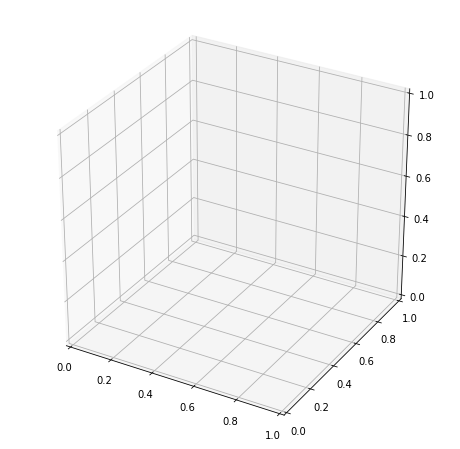

In [0]:
# Pinta una gráfica con el error de validacion en eje z y los dos parámetros fundamentales en ejes X e Y

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

# Cuantas capas tiene la red
ejeX = np.array([1, 2, 3])
#Cuantas neuronas tiene cada capa
ejeY = np.array([32, 64, 128]) 
# error
#ejeZ = np.array([[error]])
x = []
y = []
z = []

for i, capas in enumerate(ejeX):
    
    for j, neuronas in enumerate(ejeY):
        
        #Cogemos nuestro modelo por default, lo entrenamos y evaluamos el modelo
        print("[INFO] Corriendo el caso de {:06.4f} capas y {:06.4f} neuronas por capa".format(capas,neuronas))
        model_def = build_model()
        model_def.fit(X_trn,y_trn, epochs=4,verbose=1)
        print("[INFO] Error de validacion del modelo y Accuracy: ")
        eval = model_def.evaluate(X_trn,y_trn, verbose=1)
        error = eval[0]
        print("error: ", error, "Check the evaluation", eval) #Este será nuestro eje Z
        x.append(capas)
        y.append(neuronas)
        z.append(error)


In [0]:
def f(x,y,info_list):
    i=0
    j=0
    for var_i, var in enumerate(info_list[0]):
        if x == var:
            i = var_i
    for var_i, var in enumerate(info_list[1]):
        if y == var:
            j = var_i
    
    return info_list[2][i*3+j]

X, Y = np.meshgrid(x, y)
Z = f(X,Y, [x,y,z])

print( X, Y, Z)

#X = np.array(x)
#Y = np.array(y)
#Z = np.array(z)
fig = plt.figure(figsize=(8,8))
# Agregamos un plano 3D
ax1 = fig.add_subplot(111,projection='3d')
ax1.plot_wireframe(X, Y , Z)
#ax1.plot_surface(X,Y,Z)
#ax1.scatter3D(X,Y,Z)
plt.title('ERROR DE VALIDACIÓN MEDIO')
plt.xlabel('CAPAS OCULTAS')
plt.ylabel('DENSIDAD DE CAPAS OCULTAS')
ax1.set_zlabel('\n ERROR DE VALIDACIÓN MEDIO TRAS 4 ENTRENAMIENTOS')
plt.grid()
plt.show()

ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Ejercicio 3 - Utiliza la red para predecir y entender

In [0]:
# Implementa una arquitectura similar a la LeNet que hemos visto y asegúrate que la precisión supera los 99%
# Fuentes:
# http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
# https://www.kaggle.com/curiousprogrammer/lenet-5-cnn-with-keras-99-48 
import os 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
#print(os.listdir('/'))

#Preparación de datos
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1)  
X_test = X_test.reshape(-1, 28, 28, 1)      
X_train = X_train / 255
X_test = X_test / 255
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

#Modelo

model = tf.keras.Sequential([
    layers.Conv2D(32, 5, activation='relu', name='conv1' , input_shape=(28, 28, 1), padding='same'),
    layers.MaxPooling2D(2, strides=2, padding='same'),
    layers.Conv2D(64, 5, activation='relu', padding='valid', name='conv2'),
    layers.MaxPooling2D(2, strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])
model.summary()

#Compilamos
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

os.makedirs('./log',exist_ok=True)
log = keras.callbacks.TensorBoard(log_dir='./log',histogram_freq=1,embeddings_freq=0,embeddings_layer_names=None)

#Data augmentation con rotaciones, transformaciones, recorte y zoom, ¡vamos a por ese 99% de accuracy!
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,zoom_range=0.2)
datagen.fit(X_train)                                         

model.fit_generator(datagen.flow(X_train, y_train, batch_size=100), steps_per_epoch=len(X_train)/100, 
                    epochs=10, validation_data=(X_test, y_test))

#puntuaciones
score = model.evaluate(X_test, y_test, batch_size=32)
print('Error de validación & Accuracy: ',score)


['$GetCurrent', '$Recycle.Bin', 'Archivos de programa', 'Config.Msi', 'Documents and Settings', 'hiberfil.sys', 'hp', 'inetpub', 'Intel', 'OneDriveTemp', 'PerfLogs', 'Program Files', 'Program Files (x86)', 'ProgramData', 'Recovery', 'swapfile.sys', 'SWSetup', 'System Volume Information', 'SYSTEM.SAV', 'tmp', 'tools', 'Users', 'Windows', 'Windows10Upgrade']
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
________________________

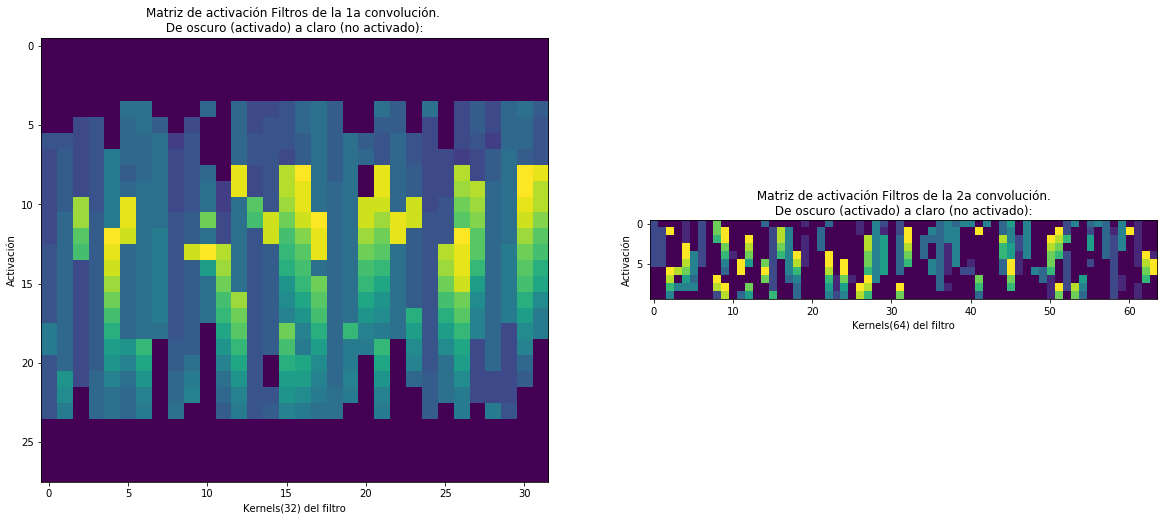


 Número que intenta predecir nuestra red: 


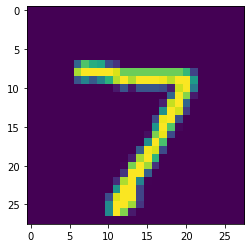


 Mapas de activación de nuestras convoluciones: 
Primera capa


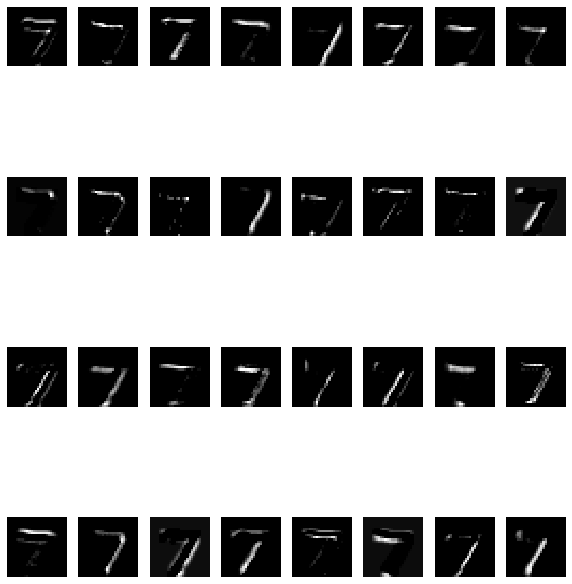

Segunda capa


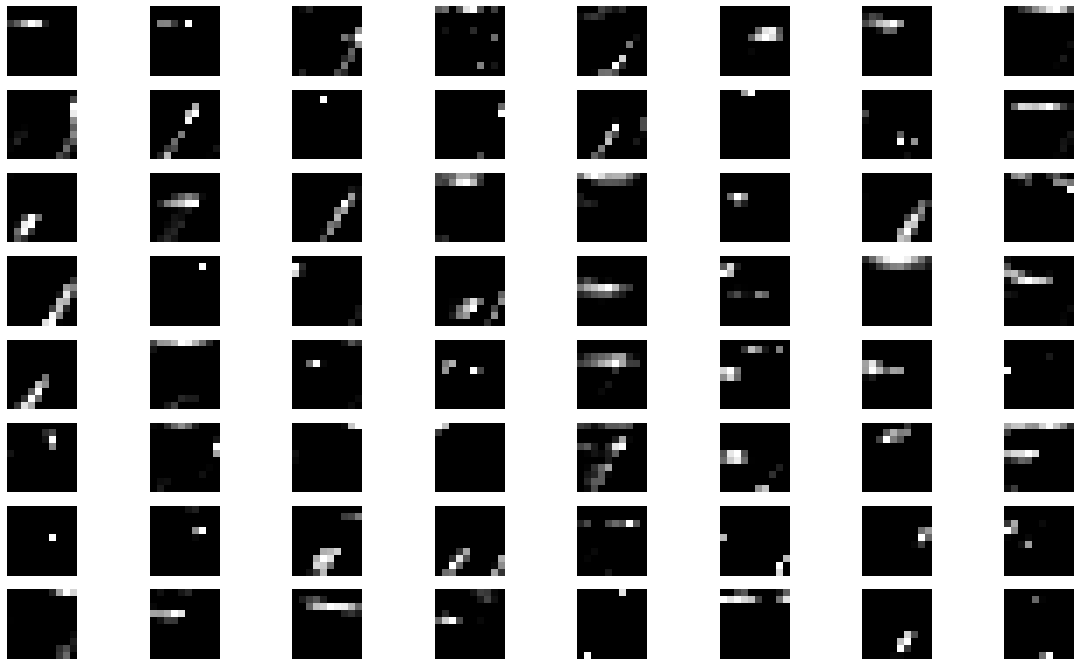

In [0]:
 
# Intenta evaluar el efecto de la primera capa de convolución en una predicción.
# ¿Qué hacen los filtros de la convolución con los números?

# Para obtener el output de capas intermedias podemos nombrar las capas con un atributo "name"
# Podéis comprobar que ya lo hemos hecho en nuestro modelo. Y procedemos como nos cuenta la
# documentación de keras en el apartado: 'How can I obtain the output of an intermediate layer (feature extraction)?'
# aquí: https://keras.io/getting_started/faq/
# ¿Qué hace la convolución con los números?: En nuestro caso un filtro de 5x5 recorre la matriz de la imagen
# generando una matriz de salida que "dibuja" las características distintivas de la imagen original,
# que en el ejemplo que estamos prediciendo sería el primer número (un 7).

layer_conv1 = keras.Model(inputs=model.input, outputs=model.get_layer('conv1').output)
output_conv1 = layer_conv1.predict(X_test)
pred = np.argmax(output_conv1, axis=1)
#print('Efecto de la 1a convolución: ' , pred[0])


# Dibuja los resultados de los filtros de convolución del nivel 1
# Dibuja los resultados de los filtros de convolución del nivel 2

#Hacemos el mismo proceso para la segunda convolución:

layer_conv2 = keras.Model(inputs=model.input, outputs=model.get_layer('conv2').output)
output_conv2 = layer_conv2.predict(X_test)
pred_2 = np.argmax(output_conv2, axis=1)

#Y pintamos las matrices activación de ambas convoluciones
import matplotlib.pyplot as plt

#Convolución 1
plt.figure(figsize=(20,20))

plt.subplot(121)
plt.title('Matriz de activación Filtros de la 1a convolución. \n De oscuro (activado) a claro (no activado): ')
plt.xlabel('Kernels(32) del filtro')
plt.ylabel('Activación')
plt.imshow(pred[0])

#Convolución 2
plt.subplot(122)
plt.title('\n Matriz de activación Filtros de la 2a convolución. \n De oscuro (activado) a claro (no activado): ')
plt.xlabel('Kernels(64) del filtro')
plt.ylabel('Activación')
plt.imshow(pred_2[0])

plt.show()

# Ahora veamos cada una de las imágenes que generan los filtros de las convoluciones
# Link para profundizar: https://www.codeastar.com/visualize-convolutional-neural-network/

#Número a predecir:
print('\n Número que intenta predecir nuestra red: ')
plt.imshow(X_test[0][:,:,0])
plt.show()

# Activaciones por convolución.Crearemos una función que nos permita acceder a
# las 32 y 64 imágenes que crean los filtros de nuestras capas de convolución
# (los mapas de activación). 

activations_conv1 = layer_conv1.predict(X_test[0].reshape(1,28,28,1)) # Convolución 1
activations_conv2 = layer_conv2.predict(X_test[0].reshape(1,28,28,1)) # Convolución 2

def display_activation(activations, col_size, row_size): 
    activation = activations
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size): 
        for col in range(0,col_size):
            ax[row][col].axis("Off")
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

print('\n Mapas de activación de nuestras convoluciones: ')
print("Primera capa")
act_conv1 = display_activation(activations_conv1, 8, 4) # 8x4 imágenes (filtro de 32 kernels de la 1a convolución)
plt.show()
print("Segunda capa")
act_conv2 = display_activation(activations_conv2, 16, 4) # 8x8 imágenes (filtro de 64 kernels de la 2a convolución)
plt.show()



 Predicciones de la red:  [7 2 1 0 4]

 Números a predecir: 



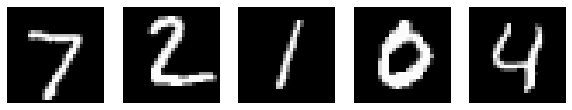

In [0]:

# Utiliza la red para predecir números 

#Por ejemplo, los 5 primeros números
Y_pred = model.predict(X_test) 
y_pred = np.argmax(Y_pred, axis=1)

print('\n Predicciones de la red: ', y_pred[:5])
print('\n Números a predecir: \n')
figure = plt.figure(figsize=(10,10))
for i in range(5):
    figure.add_subplot(1,5,i+1)
    plt.imshow(X_test[i,:,:,0],cmap="gray")
    plt.axis("off")


# BONUS - ¿Cómo harías un sistema de hyperparameter tuning que automáticamente te dé la mejor red?

En nuestro ejemplo del Hyperparameter tuning ya lo hemos implementado. Comprobar.

# BONUS - ¿Identifica la cantidad óptima de dropout aplicable al caso de clasificación de MNIST?
( 2. Crear el modelo)
El dropout mueve el punto de la presentación y cambia el momento en el que estamos haciendo overfiting 